# Train Dataset

### Files

**train_clinical_data.csv**

`visit_id` - ID code for the visit.<br>
`visit_month` - The month of the visit, relative to the first visit by the patient.<br>
`patient_id` - An ID code for the patient.<br>
`updrs_[1-4]` - The patient's score for part N of the [Unified Parkinson's Disease Rating Scale](https://www.movementdisorders.org/MDS/MDS-Rating-Scales/MDS-Unified-Parkinsons-Disease-Rating-Scale-MDS-UPDRS.htm). Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.<br>
`upd23b_clinical_state_on_medication` - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.<br>

**supplemental_clinical_data.csv** Clinical records without any associated CSF samples. This data is intended to provide additional context about the typical progression of Parkinsons. Uses the same columns as train_clinical_data.csv.

**train_peptides.csv** Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

`visit_id` - ID code for the visit. <br>
`visit_month` - The month of the visit, relative to the first visit by the patient. <br>
`patient_id` - An ID code for the patient. <br>
`UniProt` - [The UniProt ID code](https://www.uniprot.org/id-mapping) for the associated protein. There are often several peptides per protein. <br>
`Peptide` - The sequence of amino acids included in the peptide. See [this table](https://en.wikipedia.org/wiki/Amino_acid#Physicochemical_properties_of_amino_acids) for the relevant codes. Some rare annotations may not be included in the table. The test set may include peptides not found in the train set. <br>
`PeptideAbundance` - The frequency of the amino acid in the sample. <br>

**train_proteins.csv** Protein expression frequencies aggregated from the peptide level data.

`visit_id` - ID code for the visit.<br>
`visit_month` - The month of the visit, relative to the first visit by the patient.<br>
`patient_id` - An ID code for the patient.<br>
`UniProt` - [The UniProt ID code](https://www.uniprot.org/id-mapping) for the associated protein. There are often several peptides per protein. The test set may include proteins not found in the train set.<br>
`NPX` - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.<br>





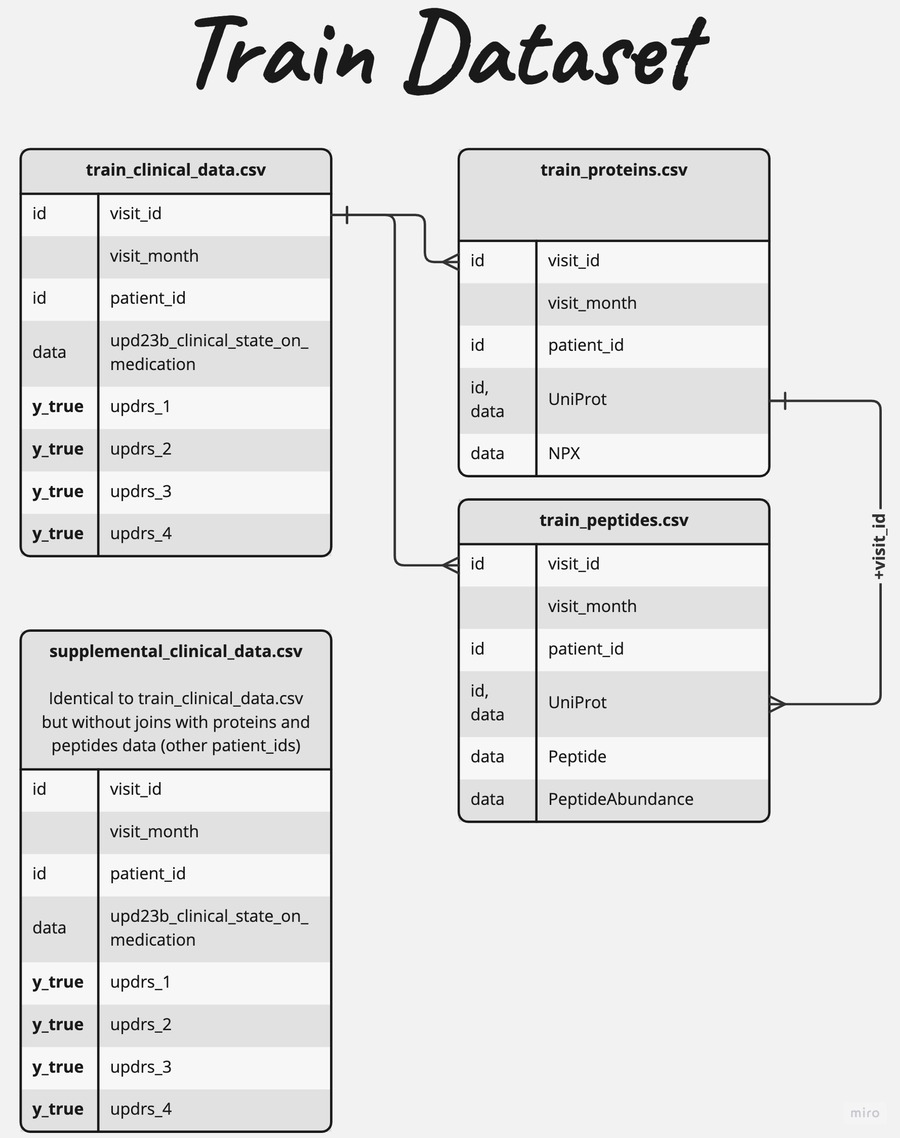

In [1]:
import sys
sys.path.append('/kaggle/input/amp-parkinsons-disease-progression-prediction')

import pandas as pd
import numpy as np

In [2]:
train_clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')[
    ['visit_id', 'patient_id', 'visit_month', 'upd23b_clinical_state_on_medication', 'updrs_1', 'updrs_2','updrs_3', 'updrs_4']]

train_clinical_data[train_clinical_data.patient_id == 55]

,visit_id,patient_id,visit_month,upd23b_clinical_state_on_medication,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,NaN,10.0,6.0,15.0,NaN
1,55_3,55,3,NaN,10.0,7.0,25.0,NaN
2,55_6,55,6,NaN,8.0,10.0,34.0,NaN
3,55_9,55,9,On,8.0,9.0,30.0,0.0
4,55_12,55,12,On,10.0,10.0,41.0,0.0
5,55_18,55,18,On,7.0,13.0,38.0,0.0
6,55_24,55,24,On,16.0,9.0,49.0,0.0
7,55_30,55,30,On,14.0,13.0,49.0,0.0
8,55_36,55,36,On,17.0,18.0,51.0,0.0
9,55_42,55,42,On,12.0,20.0,41.0,0.0


## What do we have?

* Basically, we have patients (`patiend_id`) who periodically visit (`visit_id`) a doctor and undergo medical examinations. The previous table shows visits for `patiend_id = 55` over time. This data can be viewed as a time series (`visit_month` column as date).
* **train_clinical_data.csv + supplemental_clinical_data.csv** with **y_true** (updrs_1, updrs_2, updrs_3, updrs_4) data. Some numbers measuring various aspects of Parkinson's disease.
* For some visits (`visit_id`) from **train_clinical_data.csv** we have additional medical test data in **train_proteins.csv** (some measurements of proteins) and in **train_peptides.csv** (some measurements of peptitedes). **train_peptides.csv** could be joint with **train_proteins.csv**  using `key=('visit_id', 'UniProt')`.
* **supplemental_clinical_data.csv** doesn't have additional data in **train_proteins.csv** and **train_peptides.csv** (patiend_ids without this information).

# Test API

We need to explore the Test API to understand what we need to predict and how to build cross-validation correctly. 

This competition doesn't have standard test files (only examples for 2 patiend_ids) similar to train dataset without **y_true** columns. <br>
It provides test data though the special API. <br>
The following code shows that in each iteration we get **test_clinical_data, test_peptides, test_proteins** similar to train files and **sample_submission** file. At each iteration, we need to call the `env.predict` method with a file similar to **sample_submission** structure, only after calling `env.predict` we can get a new portion of data for prediction. <br>
Locally we have access only for example API with 2 patiend_ids. After submitting a notebook for scoring, our notebook will be re-run with real test dataset (hidden from us).

### Why is it so complicated with hidden test data and we need to use API instead of full access to test files?
1. It makes the prediction process close to the real application. In reality we don't know what data our model will get. If we had something like **test_clinical_data.csv, test_proteins.csv** we could use peeking at this files for feature generation even without y_true data (we could see that a big part of test data has a huge value for some proteins and try to build a model which works good for such examples, sacrificing performance for other cases).
2. For time series data, this API shows data correctly for prediction. For each iteration (time period **T**) we only have access to data (proteins, peptides, etc) at time **<= T** and predict **y_true** for **T, T+6, T+12**. If we had a file with full **test_peptides** data at once, we could use data from peptides from time period **T+12** to predict **y_true** at **T**, and this is incorrect.

More information about the best constant solution (and how to calculate this magic constants) could be found in the notebook  [Only Constants](https://www.kaggle.com/code/vitalykudelya/only-constants).

In [3]:
target_to_prediciton = {
    'updrs_1': 6, 
    'updrs_2': 6, 
    'updrs_3': 23, 
    'updrs_4': 0
}

In [4]:
import amp_pd_peptide
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

# The API will deliver four dataframes in this specific order:

iteration_to_data = {}
for iteration, (test_clinical_data, test_peptides, test_proteins, sample_submission) in enumerate(iter_test):
    print('ITERATION', iteration)
    sample_submission['patient_id'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[0]))
    sample_submission['visit_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[1]))
    sample_submission['target_name'] = sample_submission['prediction_id'].map(lambda x: 'updrs_' + x.split('_')[3])
    sample_submission['plus_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[5]))
    sample_submission['pred_month'] = sample_submission['visit_month'] + sample_submission['plus_month']
    data = {
        'test_clinical_data': test_clinical_data,
        'test_peptides': test_peptides,
        'test_proteins': test_proteins,
        'sample_submission': sample_submission
    }
    iteration_to_data[iteration] = data
    
    print(test_clinical_data.shape)
    display(test_clinical_data.head())
    display(test_peptides.head())
    display(test_proteins.head())
    display(sample_submission.head())
    print()
    print()
    
    # change rating
    for i in range(1, 5):
        target = f'updrs_{i}'
        mask_target = sample_submission['target_name'] == target
        sample_submission.loc[mask_target, 'rating'] = target_to_prediciton[target]
    
    # don't add additional columns (other than prediction_id, rating) in env.predict, it fails after submitting notebook
    env.predict(sample_submission[['prediction_id', 'rating']])
    
# you can use iteration_to_data for detailed exploration

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
ITERATION 0
(8, 5)


,visit_id,visit_month,patient_id,updrs_test,row_id
0,3342_0,0,3342,updrs_1,3342_0_updrs_1
1,3342_0,0,3342,updrs_2,3342_0_updrs_2
2,3342_0,0,3342,updrs_3,3342_0_updrs_3
3,3342_0,0,3342,updrs_4,3342_0_updrs_4
4,50423_0,0,50423,updrs_1,50423_0_updrs_1


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2


,visit_id,visit_month,patient_id,UniProt,NPX
0,50423_0,0,50423,O00391,33127.90
1,50423_0,0,50423,O00533,490742.00
2,50423_0,0,50423,O00584,43615.30
3,50423_0,0,50423,O14773,16486.60
4,50423_0,0,50423,O14791,2882.42


,prediction_id,rating,patient_id,visit_month,target_name,plus_month,pred_month
0,3342_0_updrs_1_plus_0_months,0,3342,0,updrs_1,0,0
1,3342_0_updrs_1_plus_6_months,0,3342,0,updrs_1,6,6
2,3342_0_updrs_1_plus_12_months,0,3342,0,updrs_1,12,12
3,3342_0_updrs_1_plus_24_months,0,3342,0,updrs_1,24,24
4,3342_0_updrs_2_plus_0_months,0,3342,0,updrs_2,0,0




ITERATION 1
(8, 5)


,visit_id,visit_month,patient_id,updrs_test,row_id
0,3342_6,6,3342,updrs_1,3342_6_updrs_1
1,3342_6,6,3342,updrs_2,3342_6_updrs_2
2,3342_6,6,3342,updrs_3,3342_6_updrs_3
3,3342_6,6,3342,updrs_4,3342_6_updrs_4
4,50423_6,6,50423,updrs_1,50423_6_updrs_1


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,3342_6,6,3342,O00391,NEQEQPLGQWHLS,14564.0
1,3342_6,6,3342,O00533,GNPEPTFSWTK,96318.4
2,3342_6,6,3342,O00533,IEIPSSVQQVPTIIK,182527.0
3,3342_6,6,3342,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,38422.5
4,3342_6,6,3342,O00533,SMEQNGPGLEYR,34676.6


,visit_id,visit_month,patient_id,UniProt,NPX
0,3342_6,6,3342,O00391,14564.0
1,3342_6,6,3342,O00533,616804.0
2,3342_6,6,3342,O00584,61418.1
3,3342_6,6,3342,O14498,27830.1
4,3342_6,6,3342,O14773,14959.2


,prediction_id,rating,patient_id,visit_month,target_name,plus_month,pred_month
0,3342_6_updrs_1_plus_0_months,0,3342,6,updrs_1,0,6
1,3342_6_updrs_1_plus_6_months,0,3342,6,updrs_1,6,12
2,3342_6_updrs_1_plus_12_months,0,3342,6,updrs_1,12,18
3,3342_6_updrs_1_plus_24_months,0,3342,6,updrs_1,24,30
4,3342_6_updrs_2_plus_0_months,0,3342,6,updrs_2,0,6


### What we see in our example of test API?
* At each iteration, we need to predict **y_true** for patient_id 3342 and 50423.
* At iteration 0 we have `visit_month = 0` and we need to predict for each patient_id **y_true** (updrs_1, updrs_2, updrs_3, updrs_4) at visit_month (0+0, 0+6, 0+12, 0+24).
* At iteration 1 we have `visit_month = 6` and we need to predict for each patient_id **y_true** (updrs_1, updrs_2, updrs_3, updrs_4) at visit_month (6+0, 6+6, 6+12, 6+24). At least the main hypothisis is that in the [discussion](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/396161).
* We should replace column `rating` in **sample_submission** with our predictions.
* Acording to the update [Evaluation updates scheduled for March 14th [Updates are now live]](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/394534) "There are some rows in the solution file that should not have been scored. Those will be ignored going forward. Specifically all predictions prior to a patient's very first protein sample will be ignored, such as visit month zero for patient 3342. We are still requiring predictions to be made for those rows so that old submissions remain valid and can be rescored."

# Metric

Metric in this competitions is SMAPE+1. Read the update [Evaluation updates scheduled for March 14th [Updates are now live]](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/394534).

$${\rm SMAPE+1} = \frac{100}{n} \sum_{i=1}^n \frac{|(F_i+1) - (A_i+1)|}{(|F_i+1| + |A_i+1|) / 2}, $$
where $A_i$ is the actual value and $F_i$ is the forecast value. It's just SMAPE metric with +1 to y_pred and y_true.

# Cross-validation Tips
* For `visit_month=T` it's possible to use any data with `visit_month<=T` for feature generation.
* We need to build a model (models) which predicts **y_true** (updrs_1, updrs_2, updrs_3, updrs_4) at `T` and some `T+n`.
* `patient_id` in test dataset are new (without intersection with data in train), therefore we can divide dataset for validation by `patient_id` into groups. (this conclusion is based on my experiments, this is not official information).
* All predictions prior to a patient's very first protein sample will be ignored [Evaluation updates scheduled for March 14th [Updates are now live]](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/394534). 

The following code shows the construction of **y_trues** for train dataset (one patient_id) similar to test API (only plus 0, 6, 12, 24 months). </br>
All columns with `updrs` substring is our **y_true**.

In [5]:
patient_id = train_clinical_data[train_clinical_data.patient_id == 55].copy()

for plus_month in [6, 12, 24]:
    patiend_id_month_shift = patient_id[['visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    patiend_id_month_shift['visit_month'] -= plus_month
    patiend_id_month_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    patient_id = patient_id.merge(patiend_id_month_shift, how='left', on='visit_month')

patient_id

,visit_id,patient_id,visit_month,upd23b_clinical_state_on_medication,updrs_1,updrs_2,updrs_3,updrs_4,updrs_1_plus_6,updrs_2_plus_6,updrs_3_plus_6,updrs_4_plus_6,updrs_1_plus_12,updrs_2_plus_12,updrs_3_plus_12,updrs_4_plus_12,updrs_1_plus_24,updrs_2_plus_24,updrs_3_plus_24,updrs_4_plus_24
0,55_0,55,0,NaN,10.0,6.0,15.0,NaN,8.0,10.0,34.0,NaN,10.0,10.0,41.0,0.0,16.0,9.0,49.0,0.0
1,55_3,55,3,NaN,10.0,7.0,25.0,NaN,8.0,9.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,NaN,8.0,10.0,34.0,NaN,10.0,10.0,41.0,0.0,7.0,13.0,38.0,0.0,14.0,13.0,49.0,0.0
3,55_9,55,9,On,8.0,9.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,On,10.0,10.0,41.0,0.0,7.0,13.0,38.0,0.0,16.0,9.0,49.0,0.0,17.0,18.0,51.0,0.0
5,55_18,55,18,On,7.0,13.0,38.0,0.0,16.0,9.0,49.0,0.0,14.0,13.0,49.0,0.0,12.0,20.0,41.0,0.0
6,55_24,55,24,On,16.0,9.0,49.0,0.0,14.0,13.0,49.0,0.0,17.0,18.0,51.0,0.0,17.0,16.0,52.0,0.0
7,55_30,55,30,On,14.0,13.0,49.0,0.0,17.0,18.0,51.0,0.0,12.0,20.0,41.0,0.0,12.0,18.0,51.0,0.0
8,55_36,55,36,On,17.0,18.0,51.0,0.0,12.0,20.0,41.0,0.0,17.0,16.0,52.0,0.0,23.0,21.0,56.0,0.0
9,55_42,55,42,On,12.0,20.0,41.0,0.0,17.0,16.0,52.0,0.0,12.0,18.0,51.0,0.0,NaN,NaN,NaN,NaN
